# MixMatch Training for Binary Classification

In [48]:
import torch
import torchinfo
import matplotlib.pyplot as plt
import os

In [49]:
import mixmatch
import data_utils
import data_pl_utils
import viz_utils
import models

In [50]:
import importlib
print(importlib.reload(mixmatch))
print(importlib.reload(data_pl_utils))
print(importlib.reload(data_utils))
print(importlib.reload(viz_utils))
print(importlib.reload(models))

<module 'mixmatch' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\mixmatch.py'>
<module 'data_pl_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\data_pl_utils.py'>
<module 'data_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\data_utils.py'>
<module 'viz_utils' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\viz_utils.py'>
<module 'models' from 'c:\\Users\\josep\\Code\\School\\L3D\\Project\\PL\\models.py'>


# Configuration

In [51]:
device = 'cuda'
# device = 'cpu'

In [52]:
PL_DATA_DIR = os.environ.get('DATA_DIR', os.path.abspath('../l3d_pn_dataset500PL'))

# 1. Setup Model

# Define the model (example using ResNet18)

In [53]:
import torch.nn as nn
class ResNetFeatureExtractor(nn.Module):
    def __init__(self, num_classes):
        super(ResNetFeatureExtractor, self).__init__()
        # Load pre-trained ResNet
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])  # Remove FC
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)  # Custom FC layer

    def forward(self, x):
        features = self.feature_extractor(x)
        features = features.view(features.size(0), -1)  # Flatten
        out = self.fc(features)
        return out

In [54]:
model = models.PretrainedResNetForPN(
    src_dataset='ImageNet1k',
    arch='ResNet10',
    model_dir='.',
    n_trainable_layers=3,
    n_target_classes=2,  # Binary classification
    seed=42
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Setup complete. Trainable parameter count=133122 over 5 tensors in layers: features.stage4.unit1.identity_conv.conv,features.stage4.unit1.identity_conv.bn,output.


In [55]:
torchinfo.summary(model, (1, 3, 224, 224),
                  row_settings=['var_names'],
                  col_names=["output_size", "num_params"],
                  col_width=18)

Layer (type (var_name))                                 Output Shape       Param #
PretrainedResNetForPN (PretrainedResNetForPN)           [1, 2]             --
├─ResNet (model)                                        [1, 2]             --
│    └─Sequential (features)                            [1, 512, 1, 1]     --
│    │    └─ResInitBlock (init_block)                   [1, 64, 56, 56]    (9,536)
│    │    └─Sequential (stage1)                         [1, 64, 56, 56]    (73,984)
│    │    └─Sequential (stage2)                         [1, 128, 28, 28]   (230,144)
│    │    └─Sequential (stage3)                         [1, 256, 14, 14]   (919,040)
│    │    └─Sequential (stage4)                         [1, 512, 7, 7]     3,673,088
│    │    └─AvgPool2d (final_pool)                      [1, 512, 1, 1]     --
│    └─Linear (output)                                  [1, 2]             1,026
Total params: 4,906,818
Trainable params: 133,122
Non-trainable params: 4,773,696
Total mult-adds (Uni

# 2. Prepare Data

# Create initial data loaders

In [56]:
train_loader, val_loader, test_loader = data_utils.make_data_loaders(
    root=PL_DATA_DIR,
    batch_size=32,
    n_samples_per_class_trainandvalid=125,
    frac_valid=0.2
)


splitname   0   1
 lp_train 100 100
 lp_valid  25  25
  lp_test 125 125


# Create MixMatch specific loaders (labeled and unlabeled splits)

# 3. Initialize MixMatch

In [ ]:
mixmatch = mixmatch.MixMatch(
    model=model,
    num_augmentations=3,
    temperature=0.5,
    alpha=0.75,
    lambda_u=50,
    device=device
)

# 4. Train Model

In [58]:
# Define optimizer with only trainable parameters
optimizer = torch.optim.Adam(model.trainable_params.values(), lr=0.0001)

model, history = mixmatch.train(
    tr_loader=train_loader,
    va_loader=val_loader,
    num_epochs=100,
    learning_rate=0.0001,  # This will be used if optimizer is not provide
    optimizer=optimizer  # Pass the custom optimizer
)


  1%|          | 1/101 [00:00<01:14,  1.35it/s, tr_loss=nan, va_loss=0.856, va_acc=48]c:\Users\josep\Code\School\L3D\Project\PL\mixmatch.py:181: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  Lx = Lx + float(l2pen_mag) / n_train * loss_l2
 30%|██▉       | 30/101 [00:45<01:46,  1.50s/it, tr_loss=0.102, va_loss=1.6, va_acc=50, batch_done=2]  


KeyboardInterrupt: 

# 5. Visualize Results

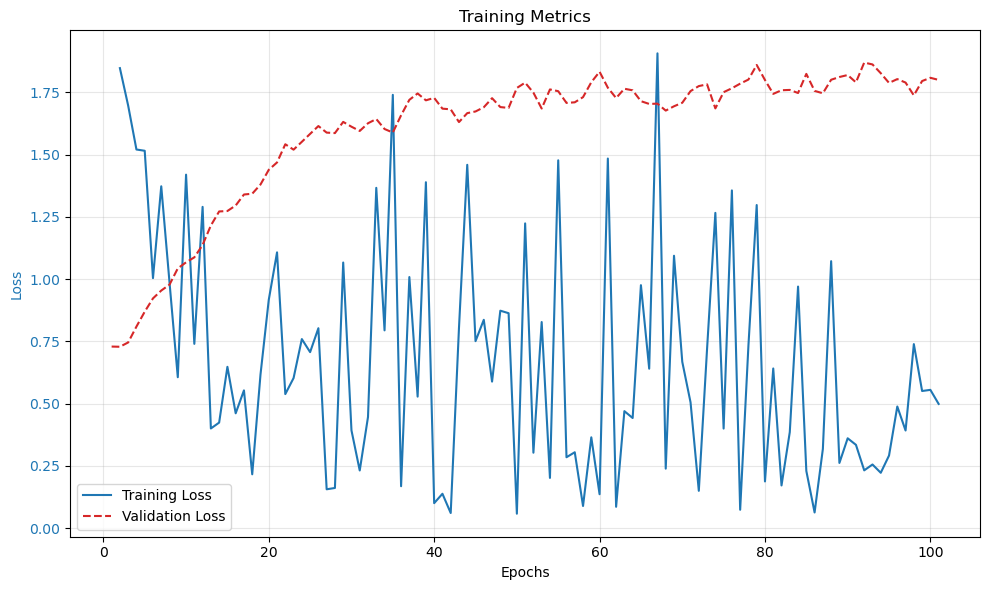

In [47]:
fig = viz_utils.plot_training_metrics(
    training_history=history,
)
plt.show()